# The t-distribution

  * Author: Paul M. Magwene
  * Date: 03 Mar 2016


In our last lecture on hypothesis testing, we introduced the idea of comparing a statistic of interest (usually the mean) as estimated from a sample, to the sampling distribution of that same statistic under the null hypothesis (i.e. assuming the null hypothesis were true).  This logically led to the idea of p-values as a measure of the probability getting a value of the statistic of interest that is *at least as extreme* as what we observed in our sample, if the null hypothesis were true.

## Review: P-values for sample means under the null hypothesis

Under the assumption that:

* The observations in are sample are independent
* The observations come from a population nearly normal distribution, $\sim N(\mu,\sigma)$ 
* The sample size is relatively large ($n \geq 30$)

We learned that the **sampling distribution of the mean** for samples of size $n$ is $\sim N(\mu,\sigma/\sqrt{n})$. We call the standard deviation of the sampling distribution of the mean, $\sigma/\sqrt{n}$, the "standard error of the mean" (${SE}_\overline{x}$).

To estimate a p-value (relative to the null hypothesis) for our observed value of the mean, $\overline{x}$, we  calculated a z-score:

\begin{eqnarray*}
z &=& \frac{\overline{x} - \mu}{\sigma/\sqrt{n}}  \\
  &=& \frac{\overline{x} - \mu}{{SE}_\overline{x}}
\end{eqnarray*}

Using this z-score we then calculate one- or two-tailed probabilities for observing z-scores as extreme of $z$ (remember that z-scores should be $N(0,1)$).  When testing against a null hypothesis where the mean $\mu_{H0}$ we subsitute this value for $\mu$.

Since in reality we don't know population standard deviation, $\sigma$, we use the sample standard deviation, $s$ instead to estimate the standard error of the mean.

## What happens when our sample size, $n$, is small?

One of the important assumptions underlying the disccusion above was that the size of our sample was relatively large.  In the code cells that follow we're going to use simulations to explore what happens when that assumption is violated.  This will help us develop an understanding of the "t-distribution"


In [1]:
# standard imports

%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('bmh')

### Setup the simulation

**NOTE**: I'm unusually verbose in the comments below. This is simply for exposition to help you understand what's going on in the code. We don't expect  you to be quite so chatty in your problem sets.

In [2]:
# setup the  popn distribution we're sampling from
mu, sigma = 10, 1
distn = stats.norm(loc=mu, scale=sigma)

# list of sample sizes we'll generate
ssizes = [2, 3, 4, 5, 7, 10, 20, 30]

# number of simulations to carry out *for each sample size*
nsims = 1000

# Use a list comprehension to generate the simulated samples
# for each choice of sample size. We could also have done this 
# in a for-loop.  I personally find the list comprehension 
# more readable but YMMV.
#
# The resulting list is filled with arrays of different sizes, 
# with sizes corresponding to the ssizes list above
# samples = [ [2 x 1000 array], [3 x 1000 array], ... , [30 x 1000 array] ] 

samples = [distn.rvs(size=(i, nsims)) for i in ssizes]

# calculate the means, std devs, std errors, and z-scores for each sample.
# For the first two calculations we use the argument "axis = 0" to indicate that
# we want to do the calculations "column-wise" (across the rows) of the 
# arrays in samples. 
#
# Again we use list comprehensions instead of for-loops for compactness.
smeans = [np.mean(i, axis=0) for i in samples] # sample means
sstds = [np.std(i, axis=0, ddof=1) for i in samples] # sample std devs

# When calculating the sample std errors, since we need two pieces of information,
# we use the zip function to bundle the std deviations and sample sizes into a
# tuple. Read the Python library description of `zip` to make sure you understand
# this function as it's very useful.
sse = [sstd/np.sqrt(size) for (sstd, size) in zip(sstds, ssizes)] 

# Finally we calculate z-scores for the observed means. We do the same
# bundling trick with zip that we used for calculatings SEs
zscores = [(mean-mu)/SE for (mean, SE) in zip (smeans, sse)]

### Even for small samples, the sampling deviation of the mean is well behaved

Let's first look at the sampling distribution of the mean.

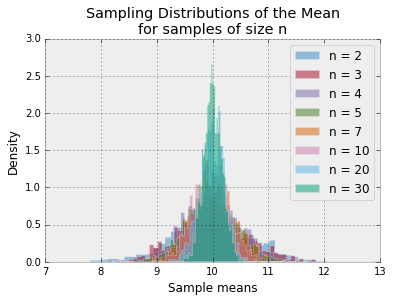

In [58]:
for i, size in enumerate(ssizes):
    plt.hist(smeans[i], alpha=0.5, bins=50, normed=True,
             histtype='stepfilled',label = "n = %d" % size)

plt.xlabel("Sample means")
plt.ylabel("Density")
plt.legend(loc='best')
plt.title("Sampling Distributions of the Mean\nfor samples of size n")
pass

As one would hope, the sample means appear to be centered around the true mean, regardless of sample size. The standard error of these distributions decreases with increasing sample size as we would expect.

Let's print of the table (nicely formatted) to confirm our visual assessment.

In [54]:
hdrfmt = "{:^7}\t{:^18}"
print(hdrfmt.format("sample", "Mean of Sampling"))
print(hdrfmt.format("size",  "Distn of the Mean"))
print(hdrfmt.format("="*7, "="*18))

fmt = "{:>7d}\t{:>18.3f}"
for i in range(len(ssizes)):
    print(fmt.format(ssizes[i], np.mean(smeans[i])))
    

sample 	 Mean of Sampling 
 size  	Distn of the Mean 
=======	==================
      2	             9.992
      3	            10.001
      4	             9.978
      5	             9.974
      7	            10.002
     10	             9.985
     20	             9.994
     30	            10.005


Here's an alternative way to print this table by creating it as a Pandas DataFrame.

In [52]:
import pandas as pd
d = pd.DataFrame()
d["sample_size"] = ssizes
d["mean_of_means"] = [np.mean(i) for i in smeans]
d

,sample_size,mean_of_means
0,2,9.992351
1,3,10.001171
2,4,9.978055
3,5,9.973690
4,7,10.001724
5,10,9.985414
6,20,9.994011
7,30,10.004647


### For small samples, sample standard deviations systematically underestimate the population standard deviation

Now we turn to "sampling distributions of the standard deviation". Like  sampling distributions of the mean, we would hope that the sampling distributions of the standard deviation should be centered around the true population value, $\sigma$.  

In our simulation we specified that $\sigma = 1$ for the underlying population. Let's examine that samples of size $n={3, 5}$ and $30$.

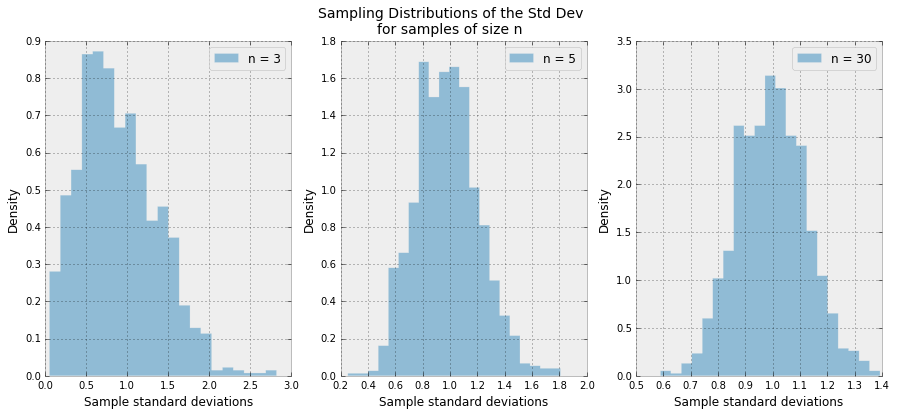

In [79]:
idx3 = ssizes.index(3)  # do you know what index does? if not, look it up!
idx10 = ssizes.index(10)
idx30 = ssizes.index(30)

ss = [3,5,30]
idxs = [idx3, idx10, idx30]

fig, axes = plt.subplots(1, 3)
fig.set_size_inches(15,6)

for i in range(len(ss)):
    ax = axes[i]
    ax.hist(sstds[idxs[i]], alpha=0.5, bins=21, normed=True,
            histtype='stepfilled',label = "n = %d" % ss[i])
    ax.set_xlabel("Sample standard deviations")
    ax.set_ylabel("Density")
    ax.legend(loc='best')

fig.suptitle("Sampling Distributions of the Std Dev\nfor samples of size n", 
             fontsize=14)
pass

Uh oh!  There's very clear indication that the the sampling distribution of standard deviations is *not* centered around 1 for $n=3$, and it looks like that may be the case for $n=5$.  

To explore this further, let's generate a plot that shows, for each sample size $n$, the mean of the sampling distribution of the standard deviation.

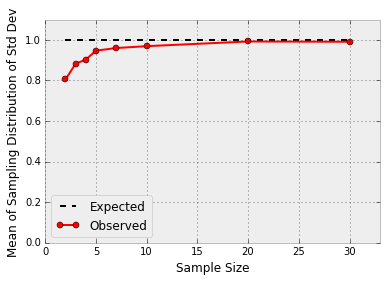

In [5]:
expected_stds = np.ones_like(ssizes)  # all expected standard deviations are 1

mean_stds = [np.mean(i) for i in sstds]

plt.plot(ssizes, expected_stds, linestyle='dashed', color='black',
        label="Expected")

plt.plot(ssizes, mean_stds, marker='o', color='red', 
         label="Observed")


plt.xlabel("Sample Size")
plt.ylabel("Mean of Sampling Distribution of Std Dev")
plt.xlim(0, max(ssizes)*1.1)
plt.ylim(0, sigma * 1.1)
plt.legend(loc='best')
pass

The above plot suggests that for samples where $n < 30$ we tend get biased estimates of the population standard deviation (even using our standard "unbiased estimator"). However, for samples of $n \geq 30$ the bias is small or non-existant.

### Underestimates of the standard deviation given small $n$ lead to overly dispersed sample mean z-scores

Now we'll look at the distribution of estimated z-scores of the sample mean relative to the true population mean. We expect that z-scores should have a mean of 0 and a standard deviation of 1. 

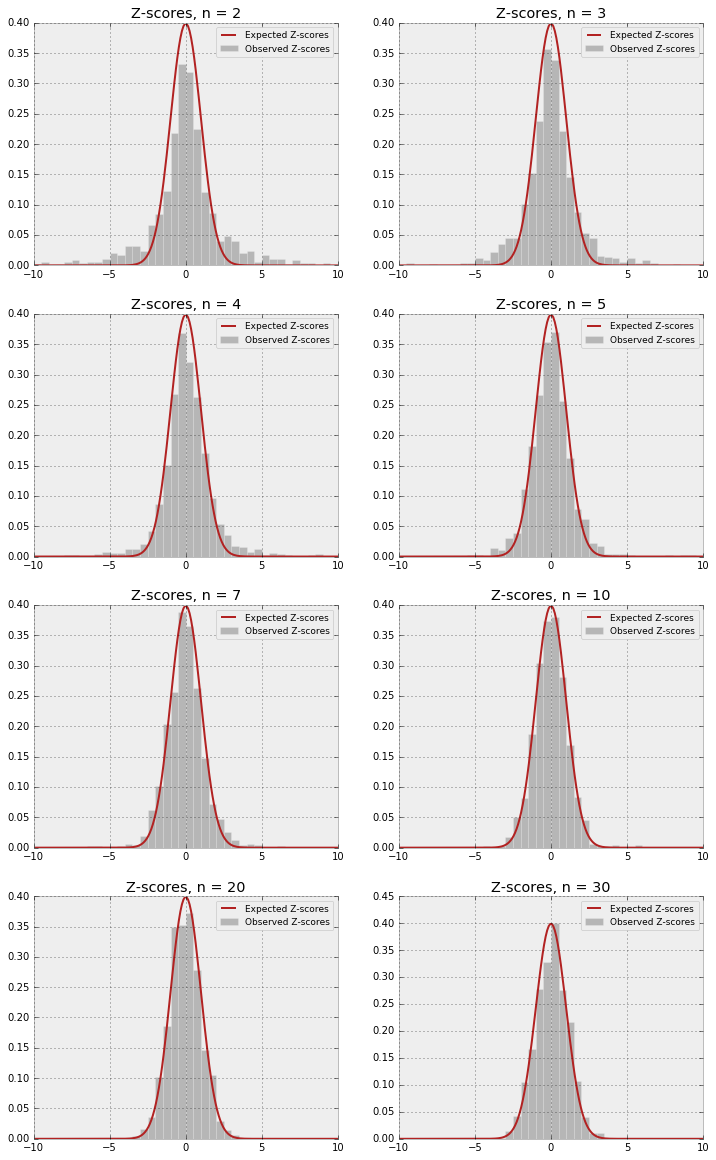

In [6]:
fig, plotmtx = plt.subplots(nrows=4, ncols=2)
fig.set_size_inches(12,20)

x = np.linspace(-10, 10, 200)
expected_pdf = stats.norm.pdf(x)

# plot first 8 distributions of z-scores
ct = 0
for row in plotmtx:
    for subplot in row:
        subplot.hist(zscores[ct], bins=np.arange(-10,10,0.5),
                     normed=True, color='gray', alpha=0.5, label="Observed Z-scores")
        subplot.plot(x, expected_pdf, color='firebrick',label="Expected Z-scores")
        subplot.legend(loc='best', fontsize=9)
        subplot.set_title("Z-scores, n = {:d}".format(ssizes[ct]))
        ct += 1

Examining the plots above, we see that for the smallest sample sizes the observed z-scores of the mean have much heavier tails than we predict.  As sample size increases, this effect becomes less and less noticable such that by the time $n=30$ the expected normal PDF fits the observed z-scores very well.  The heavy tails at small $n$ are driven by the fact that small samples tend to underestimate the population standard deviation.

## The t-distribution is the appropriate distribution for describing sample mean z-scores when $n$ is small

The problem of inflated mean z-scores was recognized in the early 20th century by William Gosset, an employee at the Guinness Brewing Company. He published a paper, under the pseudonym "Student", giving the appropriate distribution for describing z-scores as a function of the sample size $n$.  Gosset's distribution is known as the "t-distribution".

The t-distribution is specified by a single parameter, called **degrees of freedom ($df$)** where ${df} = n - 1$.  As $df$ increases, the t-distribution becomes more and more like the normal such that when $n \geq 30$ it's nearly indistinguishable from the standard normal distribution.

In the figures below we compare the t-distribution and the normal distribution for their fit to our simulated data at $n = {2, 3, 10}$.

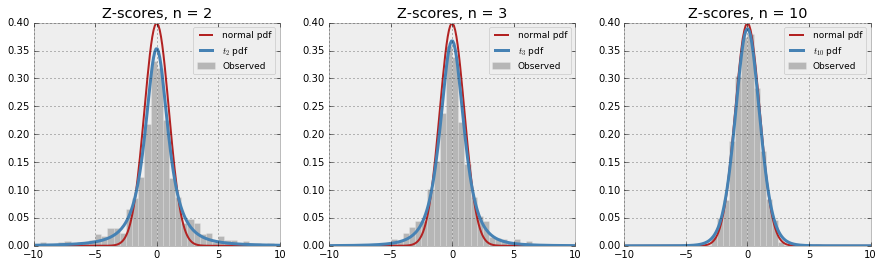

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(15,4)

x = np.linspace(-10, 10, 200)
norm_pdf = stats.norm.pdf(x)

z2 = zscores[ssizes.index(2)]
z3 = zscores[ssizes.index(3)]
z10 = zscores[ssizes.index(10)]

ax1.hist(z2, bins=np.arange(-10,10,0.5), 
         normed=True, color='gray', alpha=0.5, label="Observed")
ax1.plot(x, norm_pdf, color='firebrick', label="normal pdf")
ax1.plot(x, stats.t.pdf(x, df=2), color='steelblue',
         linewidth=3, label="$t_2$ pdf")
ax1.legend(loc='best', fontsize=9)
ax1.set_title("Z-scores, n = 2")

ax2.hist(z3, bins=np.arange(-10,10,0.5), 
         normed=True, color='gray', alpha=0.5, label="Observed")
ax2.plot(x, norm_pdf, color='firebrick',label="normal pdf")
ax2.plot(x, stats.t.pdf(x, df=3), color='steelblue',
         linewidth=3, label="$t_{3}$ pdf")
ax2.legend(loc='best', fontsize=9)
ax2.set_title("Z-scores, n = 3")

ax3.hist(z10, bins=np.arange(-10,10,0.5), 
         normed=True, color='gray', alpha=0.5, label="Observed")
ax3.plot(x, norm_pdf, color='firebrick',label="normal pdf")
ax3.plot(x, stats.t.pdf(x, df=10), color='steelblue',
         linewidth=3, label="$t_{10}$ pdf")
ax3.legend(loc='best', fontsize=9)
ax3.set_title("Z-scores, n = 10")


pass

### More comparisons of the t- and normal distributions


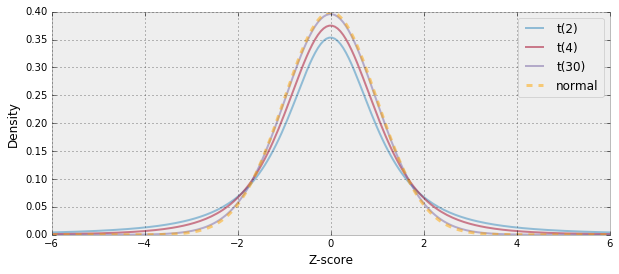

In [29]:
fig = plt.figure()
fig.set_size_inches(10,4)

df = [2, 4, 30]
x = np.linspace(-6, 6, 200)

for i in df:
    plt.plot(x, stats.t.pdf(x, df=i), alpha=0.5, label='t({:d})'.format(i))
    
plt.plot(x, stats.norm.pdf(x), alpha=0.5, linestyle='dashed', label='normal',
        color='orange', linewidth=3)

plt.xlabel("Z-score")
plt.ylabel("Density")
plt.legend(loc='best')
pass

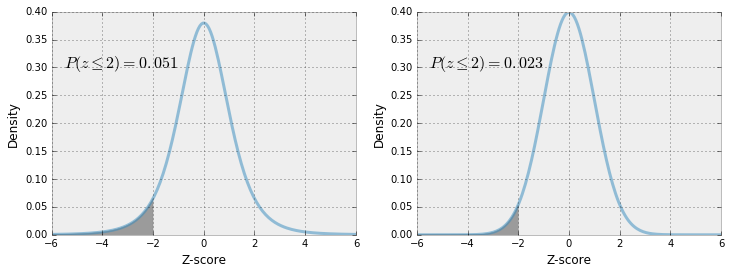

In [68]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(12,4)

x = np.linspace(-6, 6, 200)
leftx = np.linspace(-6, -2, 100)

tProbLess2 = stats.t.cdf(-2, df=5)
nProbLess2 = stats.norm.cdf(-2)

ax1.plot(x, stats.t.pdf(x, df=5), alpha=0.5, linewidth=3, label='t({:d})'.format(i))
ax1.fill_between(leftx, stats.t.pdf(leftx, df=5), color='gray', alpha=0.75)
ax1.text(-5.5, 0.3, "$P(z \leq 2) = {:.3f}$".format(tProbLess2), fontsize=16)
ax1.set_xlabel("Z-score")
ax1.set_ylabel("Density")

    
ax2.plot(x, stats.norm.pdf(x), alpha=0.5, label='normal', linewidth=3)
ax2.fill_between(leftx, stats.norm.pdf(leftx), color='gray', alpha=0.75)
ax2.text(-5.5, 0.3, "$P(z \leq 2) = {:.3f}$".format(nProbLess2), fontsize=16)
ax2.set_xlabel("Z-score")
ax2.set_ylabel("Density")

pass

## For next time
* t-confidence intervals and hypothesis testing using the t-distribution
* Mean differences for paired data
* Two-sample t-tests
